In [1]:
#!pip install openpyxl

In [2]:
#!pip install xlutils

Started Reading data from file .. DeliveryQuantity.xlsx
Started Reading data from file .. Stock-Analysis.xlsx
Started Reading data from file .. cm28JUN2019bhav.csv
Started Reading data from file .. data (4).csv
Started Reading data from file .. fo28JUN2019bhav.csv
Stock-Analyis Report Updated Successfully
Started Reading data again from file .. Stock-Analysis.xlsx for reporting.


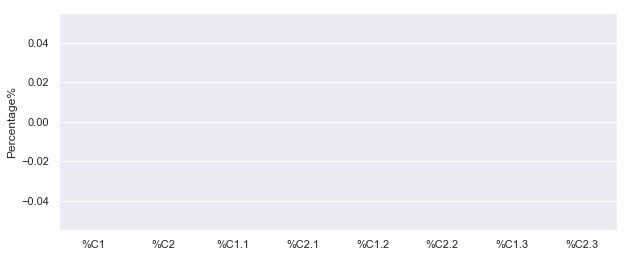

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                                    # Plotting library for Python programming language and it's numerical mathematics extension NumPy
import seaborn as sns                                              # Provides a high level interface for drawing attractive and informative statistical graphics
%matplotlib inline
sns.set()
from subprocess import check_output

import math as mathObj
from datetime import datetime
import shutil
import os as osObj
import openpyxl
from openpyxl import load_workbook
import calendar

def ReadExcelFile(pd, mathObj,Datafilename=''):
    '''
    Read the Wish list Data, Email id and Mandatory Channels
    '''
    # Load spreadsheet
    xl = pd.ExcelFile(Datafilename)
    ExcelFileName = Datafilename[Datafilename.rfind("\\")+1:] 
    for sheetname in xl.sheet_names :
        # Load a sheet into a DataFrame by name: 
        if sheetname.lower() == 'analysis' :
            df_StockReport = xl.parse(sheetname,skiprows=1)
            #print("Count after adding wishlist {}".format(df_myCurrentPack['Channel_Name'].count()))
        elif sheetname.lower()=='sheet1' and ExcelFileName in ['DeliveryQuantity.xlsx']:
            df_StockReport = xl.parse(sheetname)
             # iterating the columns 
            for col in df_StockReport.columns: 
                #Process the PriceChange , Traded Value, TOTALTRADES columns
                #covert number data into numerical values
                if str.lower(col) == 'name of security':  
                    #Add percentage to Daily Valatility and Annual Volatality
                    df_StockReport = df_StockReport.rename(columns = {col:"SYMBOL"}) 
                elif str.lower(col) == 'quantity traded':
                     df_StockReport = df_StockReport.rename(columns = {col:"SERIES"}) 
                elif str.lower(col) == '% of deliverable quantity to traded quantity':  
                    #Add percentage to Daily Valatility and Annual Volatality
                    df_StockReport = df_StockReport.rename(columns = {col:"DELIVERYQTY"})  
   
    #**Fetch & Store the data of MyPack in a new Data frame df_myCurrentPack and the Packs in df_OtherAvailablePacks End Code***
    
    #********Clean up the data numeric data in the dataframe Begin Code*******************************
    for col in df_StockReport.columns: 
        if col not in ['SYMBOL','Nifty 50','FO','SERIES']:
            df_StockReport[col] =pd.to_numeric(df_StockReport[col], errors='coerce')
    
    #print(df_StockReport)
    #********Clean up the data numeric data in the dataframe End Code*******************************
    return df_StockReport

def ReadCSVFile(pd, mathObj,Datafilename=''):
    '''
    Read the Data from CSV file
    '''
    #print("Reading",Datafilename)
    # Load spreadsheet
    df_csvData = pd.read_csv(Datafilename)
    #print("Reading completed",Datafilename)
    
    # iterating the columns 
    for col in df_csvData.columns: 
        #Process the PriceChange , Traded Value, TOTALTRADES columns
        #covert number data into numerical values
        if col in ['Change' , 'Traded Value(crs)','TOTALTRADES','CONTRACTS','CHG_IN_OI']:
            df_csvData[col] =pd.to_numeric(df_csvData[col], errors='coerce')
            #print(df_csvData.CurrentDayVolatility.dtype)
        elif str.lower(col) == 'symbol':  
            #Add percentage to Daily Valatility and Annual Volatality
            df_csvData = df_csvData.rename(columns = {col:"SYMBOL"})
        elif col in ['EXPIRY_DT','TiMESTAMP']:
            df_csvData[col] = pd.to_datetime(df_csvData[col])
            
    return df_csvData

#Get the path of the PriceChange and Traded Value (.CSV) and  (.csv)
osObj.getcwd()  #get the current working director (keep both the above files in the current working directory)
myListofFiles = []
myListofFiles = osObj.listdir(osObj.getcwd()) #Get all the files and directories
myListofFiles.sort(reverse=False)

blnPriceChangeTradeValueCSVFound = blnTotalTradesFound = blnDeliveryQtyExcelFound = blnConChgOICSVFound= False
blnStockAnalysisExcelFound = False
for file in myListofFiles:
    
    if file[-3:] == "csv" or file[-3:] == "CSV": #Read only the csv extensions and ignore directories 
        print("Started Reading data from file ..",file)
        MyDatafilePath = osObj.path.join(osObj.getcwd(), file)
        dfReportData = ReadCSVFile(pd,mathObj,MyDatafilePath)
        RepColNames = list(dfReportData.columns.values.tolist()) 
        if ('Change' in RepColNames and 'Traded Value(crs)' in RepColNames):
            #Store this data in PriceChangeTV dataframe
            dfPriceChangeTV = dfReportData[['SYMBOL','Change','Traded Value(crs)']].copy()
            blnPriceChangeTradeValueCSVFound =True
            #print(dfPriceChangeTV)    
        elif ('TOTALTRADES' in RepColNames):
            #Store this data TOTALTRADES dataframe
            dfReportData = dfReportData.query("SERIES=='EQ'")
            dfTotalTrades = dfReportData[['SYMBOL','SERIES','TOTALTRADES']].copy()
            #print(dfTotalTrades)
            blnTotalTradesFound = True
        elif ('CONTRACTS' in RepColNames and 'CHG_IN_OI' in RepColNames):
            #Store this data in ConChgOI dataframe
            #filter for only current month data
            
            #Get the minimum date of the Expiriy and pull that months report.
            StartDate = dfReportData["EXPIRY_DT"].min()
            ThisYear = int(StartDate.strftime("%Y"))
            ThisMonth = int(StartDate.strftime("%m"))
            ThisDay = int(StartDate.strftime("%d"))
            EndDate = StartDate.strftime(str(calendar.monthrange(ThisYear,ThisMonth)[1]) + "-" 
                                         + str(ThisMonth).zfill(3-len(str(ThisMonth).strip())) + "-%Y")
            #print(StartDate)
            #print(EndDate)
            dfReportData =  dfReportData.query("INSTRUMENT=='FUTSTK'")
            dfReportData = dfReportData[dfReportData["EXPIRY_DT"].isin(pd.date_range(StartDate, EndDate))]
            #print(dfReportData)
            dfConChgOI = dfReportData[['SYMBOL','CONTRACTS','CHG_IN_OI']].copy()
            
            blnConChgOICSVFound = True
    elif file[-4:] == "xlsx" or file[-3:] == "xls": 
        #Check if any Daily Report already exists if yes then move that to backup folder
        if file in ['Stock-Analysis.xlsx']:
            #read the stock report
            print("Started Reading data from file ..",file)
            MyDatafilePath = osObj.path.join(osObj.getcwd(), file)
            dfStockMaster = ReadExcelFile(pd,mathObj,MyDatafilePath)
            RepColNames = list(dfStockMaster.columns.values.tolist())
            blnStockAnalysisExcelFound =True
            #print (dfStockMaster)
            #print (RepColNames)
        elif file in['DeliveryQuantity.xlsx','DeliveryQuantity.xls']:
            #read the Delivery Quanitity report
            print("Started Reading data from file ..",file)
            MyDatafilePath = osObj.path.join(osObj.getcwd(), file)
            dfReportData = ReadExcelFile(pd,mathObj,MyDatafilePath)
            RepColNames = list(dfReportData.columns.values.tolist())
            #print(RepColNames)
            if ('DELIVERYQTY' in RepColNames and 'SYMBOL' in RepColNames):
                #Store this data in PriceChangeTV dataframe
                dfReportData = dfReportData.query("SERIES=='EQ'")
                dfDelQty = dfReportData[['SYMBOL','DELIVERYQTY','SERIES']].copy()
                blnDeliveryQtyExcelFound =True
                #print(dfDelQty)    

if blnStockAnalysisExcelFound == False:
    print("DID NOT FIND Stock-Analyis.xlsx FILE...HENCE CANNOT GENERATE THE REPORT")
    print("Please download the Stock-Analyis.xlsx file from https://www.nitinbhatia.in/wp-content/uploads/2018/01/Stock-Analysis.xlsx")
else:
    
    #Now perform the join and publish the data in a new file called DailyVolatality Report
    if blnPriceChangeTradeValueCSVFound == True and blnTotalTradesFound == True and blnDeliveryQtyExcelFound == True and blnConChgOICSVFound ==True:
        
        #Remove the total columns from StockMaster
        dfStockMaster = dfStockMaster.query("SYMBOL!='Totals'")
        dfFinalReport = pd.merge(dfStockMaster[['SYMBOL']],dfPriceChangeTV,how='left',on='SYMBOL')
        dfFinalReport.Change =  dfFinalReport.Change.fillna(0)
        dfFinalReport['Traded Value(crs)'] =  dfFinalReport['Traded Value(crs)'].fillna(0)
        dfFinalReport = dfFinalReport.filter(items=['SYMBOL','Change','Traded Value(crs)'])
        dfFinalReport = dfFinalReport.reset_index(drop=True)
        #Open the Stock Analysis and Read the Analysis Tab data
        xfile = openpyxl.load_workbook('Stock-Analysis.xlsx')
        #sheet = xfile.get_sheet_by_name('Sheet1')
        sheet = xfile['Analysis']

        #1********Write data of Price change and Traded Value to Stock-Analysis XLS*************
        #Columns to Edit with Price Change->COL E(Name P1)  and Trade Value ->COL O(Name TV3)

        #Start writing data from row 3
        intRow = 3 
        for index, row in dfFinalReport.iterrows():
            #print(index,row['c1'], row['c2']) 
            sheet['E'+ str(intRow)] = row['Change'] # Write the Price change to mapped column
            sheet['O'+ str(intRow)] = row['Traded Value(crs)'] # Write the Trade value to mapped column
            intRow += 1


        #2****Next Write data of TOTAL TRADES to Stock-Analysis XLS****************
        #Columns to Edit with TOTAL TRADES->COL H  (Name NT3)
        dfFinalReport = pd.merge(dfStockMaster[['SYMBOL']],dfTotalTrades,how='left',on='SYMBOL')
        dfFinalReport.TOTALTRADES =  dfFinalReport.TOTALTRADES.fillna(0)
        dfFinalReport = dfFinalReport.filter(items=['SYMBOL','TOTALTRADES'])
        dfFinalReport = dfFinalReport.reset_index(drop=True)
        #print(dfFinalReport)
        #Start writing data from row 3
        intRow = 3 
        for index, row in dfFinalReport.iterrows():
            #print(index,row['c1'], row['c2']) 
            sheet['H'+ str(intRow)] = row['TOTALTRADES'] # Write the TOTALTRADES to mapped column
            intRow += 1

        #3****Next Write data of DELIVERY QUANTITY to Stock-Analysis XLS****************
        #Columns to Edit with DELIVERYQTY->COL V  (Name DQ3)
        dfFinalReport = pd.merge(dfStockMaster[['SYMBOL']],dfDelQty,how='left',on='SYMBOL')
        dfFinalReport.DELIVERYQTY =  dfFinalReport.DELIVERYQTY.fillna(0)
        dfFinalReport = dfFinalReport.filter(items=['SYMBOL','DELIVERYQTY'])
        dfFinalReport = dfFinalReport.reset_index(drop=True)
        #print(dfFinalReport)
        #Start writing data from row 3
        intRow = 3 
        for index, row in dfFinalReport.iterrows():
            #print(index,row['c1'], row['c2']) 
            sheet['V'+ str(intRow)] = row['DELIVERYQTY'] # Write the DELIVERY QTY to mapped column
            intRow += 1

        #4****Next Write data of CONTRACTS and CHANGE in OPEN INTEREST to Stock-Analysis XLS****************
        #Columns to Edit with CHANGE in OPEN INTEREST->COL AB  (Name COI2) and CONTRACTS -> COL AE (NAME OIC3)
        dfFinalReport = pd.merge(dfStockMaster[['SYMBOL']],dfConChgOI,how='left',on='SYMBOL')
        dfFinalReport.CONTRACTS =  dfFinalReport.CONTRACTS.fillna(0)
        dfFinalReport.CHG_IN_OI =  dfFinalReport.CHG_IN_OI.fillna(0)
        dfFinalReport = dfFinalReport.filter(items=['SYMBOL','CONTRACTS','CHG_IN_OI'])
        dfFinalReport = dfFinalReport.reset_index(drop=True)
        #print(dfFinalReport)
        #Start writing data from row 3
        intRow = 3 
        for index, row in dfFinalReport.iterrows():
            #print(index,row['c1'], row['c2']) 
            sheet['AE'+ str(intRow)] = row['CONTRACTS'] # Write the Contracts to mapped column
            sheet['AB'+ str(intRow)] = row['CHG_IN_OI'] # Write the Change in Interest to mapped column
            intRow += 1

        xfile.save('Stock-Analysis.xlsx')
        print("Stock-Analyis Report Updated Successfully")
        
        
        #*************Prepare the Bullish or Bearish Analysis chart*************************
        '''
        The main difference between bullish and bearish markets is whether confidence is high and prices are rising or 
        if it is low and prices are dropping. More specifically, the terms bullish and bearish describe the actual state of 
        the market –if it is gaining value, or in an “uptrend,” or losing value in a “downtrend.”
        '''
        fig, ax = plt.subplots(figsize=(10,4))
        #fig, ax = plt.subplots(1,2,figsize=(20,8))
                
        #Assign the total columns from StockMaster to dfBullBear to draw the bar chart
        file = 'Stock-Analysis.xlsx'
        print("Started Reading data again from file ..",file,"for reporting.")
        MyDatafilePath = osObj.path.join(osObj.getcwd(), file)
        dfBullBear = ReadExcelFile(pd,mathObj,MyDatafilePath)
        dfBullBear = dfBullBear.query("SYMBOL=='Totals'")
        #print(dfBullBear)
        
        #dfBullBear = dfBullBear.filter(items=[''])
        #select all rows and col K and L, R and S, Y and Z, AH and AI 
        dfBullBear = dfBullBear.iloc[:,[10,11,17,18,24,25,33,34]]
        #BearBullCols = dfBullBear.columns.tolist()
        #PercentageValue = [dfBullBear.iloc[0:0,10:10],dfBullBear.iloc[:,11:11],dfBullBear.iloc[:,17:17],dfBullBear.iloc[:,18:18],
        #                  dfBullBear.iloc[:,24:24],dfBullBear.iloc[:,25:25],dfBullBear.iloc[:,33:33],dfBullBear.iloc[:34:34]]
        dfTranspose = dfBullBear.transpose()
        #print("Col List" , BearBullCols)
        #print("Row list" , PercentageValue)
        # Set title
        #ax.set_title('Bullish or Bearish Report')
        for col in dfTranspose.columns: 
            #Process the PriceChange , Traded Value, TOTALTRADES columns
            if len (dfTranspose.columns) == 1:
                dfTranspose = dfTranspose.rename(columns = {col:"Percentage%"})        
        
        #Draw the legends
        ax = sns.barplot( x=dfTranspose.index, y="Percentage%",data=dfTranspose)
        for i, v in enumerate(dfBullBear["Percentage%"]):
           ax.text(i , v , str(round(v,2)), color='blue', fontweight='bold')
    else:
        if blnPriceChangeTradeValueCSVFound == False :
            print("DID NOT FIND PRICE CHANGE and TRADE VALUES (FO STOCKS) CSV FILE...HENCE CANNOT GENERATE THE REPORT")
            print("Please download the FO Stocks file from https://www.nseindia.com/live_market/dynaContent/live_watch/equities_stock_watch.htm")
        elif blnTotalTradesFound == False:
            print("DID NOT FIND TOTALTRADES(Bhavcopy file) CSV FILE...HENCE CANNOT GENERATE THE REPORT")
            print("Please download the Total Trades-Bhavcopy file from https://www.nseindia.com/content/historical/EQUITIES/2019/JUN/cm28JUN2019bhav.csv.zip")
        elif blnDeliveryQtyExcelFound == False:
            print("DID NOT FIND DeliveryQuantity.xlsx FILE...HENCE CANNOT GENERATE THE REPORT")
            print("Please download the Delivery Position DAT and save it as DeliveryQuantity.xlsx file from https://www.nseindia.com/archives/equities/mto/MTO_28062019.DAT")
        elif blnConChgOICSVFound == False:
            print("DID NOT FIND CONTRACT AND CHANGE IN OPEN INTEREST Bhavcopy CSV FILE...HENCE CANNOT GENERATE THE REPORT")
            print("Please download the Contract/ChangeInOpenInterest-Bhavcopy file from https://www.nseindia.com/content/historical/DERIVATIVES/2019/JUN/fo28JUN2019bhav.csv.zip")
        elif blnPriceChangeTradeValueCSVFound == False and blnTotalTradesFound == False and blnDeliveryQtyExcelFound == False and blnConChgOICSVFound == False:
            print("DID NOT FIND PRICE CHANGE and TRADE VALUES, TOTALTRADES(Bhavcopy file),DeliveryQuantity.xlsx  and CONTRACT AND CHANGE IN OPER INTEREST Bhavcopy ...HENCE CANNOT GENERATE THE REPORT")
            